In [34]:
import os, pandas as pd, requests

DATA_RAW = "../data/raw"
DATA_INTERIM = "../data/interim"
os.makedirs(DATA_RAW, exist_ok=True)
os.makedirs(DATA_INTERIM, exist_ok=True)

# Data Pull + Cohort Filtering 

## Data Source & Scope
* **Source:** CFPB/FFIEC HMDA v2 API (public endpoint).
* **Query Parameters:**
  * Year = 2022  
  * State = California (CA)  
  * Loan type = Conventional (1)  
  * Property type = 1–4 family, site-built (1)  
  * Occupancy = Primary residence (1)  
  * Lien status = First lien (1)  
  * Loan purpose = Home purchase (1)  
  * Action taken = Loan originated (1)
* Data represents **approved, first-lien, owner-occupied, conventional home-purchase loans** — the core cohort for pricing fairness analysis.

## Column Validation & Data Integrity
* Verified all filter columns exist and applied filters sequentially with safe `.copy()` usage.  
* Converted `loan_term` to numeric (`errors="coerce"`) to ensure proper filtering.  
* Confirmed all final cohort columns have a **100% match (proportion = 1.0)** for their target filter values.  
* Retained only **site-built 1–4 unit properties** using `derived_dwelling_category`.  
* Excluded non-standard loan terms (`< 360 months`) to standardize pricing comparability.

## Results Summary
* Rows removed:
  * `loan_type`: 114,711  
  * `lien_status`: 23,559  
  * `action_taken`: 196,506  
  * `occupancy_type`: 46,881  
  * `derived_dwelling_category`: 5,470  
  * `loan_term < 360`: 5,126  
* Final dataset: **219,445 loans**, **99 columns**.

In [35]:
from io import StringIO

# Paths
DATA_RAW = "../data/raw"
os.makedirs(DATA_RAW, exist_ok=True)

# API endpoint
base_url = "https://ffiec.cfpb.gov/v2/data-browser-api/view/csv"

params = {
    "years": "2022",
    "states": "CA",
    "loanTypes": "1",      # conventional
    "propertyTypes": "1",  # 1–4 family, site-built
    "occupancyTypes": "1", # primary
    "lienStatuses": "1",    # first lien
    "loan_purposes": "1",    # purchase loans
    "action_taken": "1"  # loan originated
}

# Add User-Agent header to avoid 403
headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"
}

resp = requests.get(base_url, params=params, headers=headers)
resp.raise_for_status()




# Read CSV from response 
df_raw = pd.read_csv(StringIO(resp.text), low_memory=False)

# Manual re-filter to enforce cohort definition 
expected_filters = {
    "loan_type": 1,          # Conventional
    "lien_status": 1,        # First lien
    "loan_purpose": 1,       # Home purchase
    "action_taken": 1,       # Originated
    "occupancy_type": 1      # Primary residence
}

for col, val in expected_filters.items():
    if col in df_raw.columns:
        before = len(df_raw)
        df_raw = df_raw[df_raw[col] == val]
        removed = before - len(df_raw)
        print(f"{col}: removed {removed:,} rows not matching value {val}")

# Filter for 1–4 Unit, Site-Built Homes 
if "derived_dwelling_category" in df_raw.columns:
    before = len(df_raw)
    df_raw = df_raw[
        df_raw["derived_dwelling_category"] == "Single Family (1-4 Units):Site-Built"
    ].copy()
    removed = before - len(df_raw)
    print(f"derived_dwelling_category: removed {removed:,} non-site-built or multifamily loans")
else:
    print("'derived_dwelling_category' not found — skipping property filter.")

# Filter out non-standard loan terms (< 360 months) 
if "loan_term" in df_raw.columns:
    before = len(df_raw)
    df_raw["loan_term"] = pd.to_numeric(df_raw["loan_term"], errors="coerce")
    df_raw = df_raw[df_raw["loan_term"] >= 360].copy()
    removed = before - len(df_raw)
    print(f"loan_term: removed {removed:,} loans with terms < 360 months")
else:
    print("⚠️ 'loan_term' column not found — skipping loan term filter.")

# Confirm filter results
print("\nFinal cohort composition after re-filtering:")
for col, val in expected_filters.items():
    if col in df_raw.columns:
        print(f"{col}:", df_raw[col].value_counts(normalize=True).round(3))

# Save raw pull
raw_out = os.path.join(DATA_RAW, "hmda_ca2022_raw_approved.csv")
df_raw.to_csv(raw_out, index=False)

print("Rows, Cols:", df_raw.shape)
df_raw.head(3)

loan_type: removed 114,711 rows not matching value 1
lien_status: removed 23,559 rows not matching value 1
loan_purpose: removed 0 rows not matching value 1
action_taken: removed 196,506 rows not matching value 1
occupancy_type: removed 46,881 rows not matching value 1
derived_dwelling_category: removed 5,470 non-site-built or multifamily loans
loan_term: removed 5,126 loans with terms < 360 months

Final cohort composition after re-filtering:
loan_type: loan_type
1    1.0
Name: proportion, dtype: float64
lien_status: lien_status
1    1.0
Name: proportion, dtype: float64
loan_purpose: loan_purpose
1    1.0
Name: proportion, dtype: float64
action_taken: action_taken
1    1.0
Name: proportion, dtype: float64
occupancy_type: occupancy_type
1    1.0
Name: proportion, dtype: float64
Rows, Cols: (219445, 99)


,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2022,549300FGXN1K3HLB1R50,40900,CA,6061.0,6.061024e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4361,11.10,102400,97.88,2252,2634,0
2,2022,549300FGXN1K3HLB1R50,31084,CA,6037.0,6.037481e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4183,57.54,91100,186.97,696,1045,65
5,2022,549300FGXN1K3HLB1R50,36084,CA,6013.0,6.013322e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,6528,39.51,142800,141.91,1986,2190,52


In [36]:
print("Post-filter checks:")
print("Total rows:", len(df_raw))
print("\nDistribution by race group:")
print(df_raw["derived_race"].value_counts(normalize=True).round(3))

print("\nDistribution by lender type (top 10):")
print(df_raw["lei"].value_counts().head(10))

print("\nBasic pricing summary:")
# Ensure numeric type for rate_spread
df_raw["rate_spread"] = pd.to_numeric(df_raw["rate_spread"], errors="coerce")

print("\nBasic pricing summary:")
print(df_raw["rate_spread"].describe(percentiles=[.1, .5, .9]).round(3))

Post-filter checks:
Total rows: 219445

Distribution by race group:
derived_race
White                                        0.482
Asian                                        0.233
Race Not Available                           0.207
Joint                                        0.043
Black or African American                    0.026
American Indian or Alaska Native             0.005
Native Hawaiian or Other Pacific Islander    0.002
2 or more minority races                     0.002
Free Form Text Only                          0.000
Name: proportion, dtype: float64

Distribution by lender type (top 10):
lei
549300HW662MN1WU8550    26524
549300FGXN1K3HLB1R50    13959
KB1H1DSPRFMYMCUFXT09     9810
549300AG64NHILB7ZP05     7483
YWC0TIKBQM2JV8L4IV08     6490
6BYL5QZYBDK8S7L73M02     6080
B4TYDEB6GKMZO031MB27     5734
7H6GLXDRUGQFU57RNE97     4847
549300VZVN841I2ILS84     4429
549300BRJZYHYKT4BJ84     4365
Name: count, dtype: int64

Basic pricing summary:

Basic pricing summary:
count    2

In [37]:
# Schema check
print("Sample columns:", df_raw.columns.tolist()[:20])
print("Years:", df_raw["activity_year"].unique())
print("States:", df_raw["state_code"].unique())
print("Loan Purpose:", df_raw["loan_purpose"].unique())
print("Unique institutions (LEI):", df_raw["lei"].nunique())
print("Approval rate raw:", (df_raw["action_taken"].isin([1, 2]).astype(int).mean().round(3)))

key_cols = ["income","loan_amount","loan_to_value_ratio","rate_spread","debt_to_income_ratio"]
print(df_raw[key_cols].isna().mean().sort_values().rename("null_frac"))

for c in key_cols:
    s = pd.to_numeric(df_raw[c], errors="coerce")
    print(f"{c}: min={s.min()}, median={s.median()}, p95={s.quantile(0.95)}, max={s.max()}")

Sample columns: ['activity_year', 'lei', 'derived_msa-md', 'state_code', 'county_code', 'census_tract', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'derived_ethnicity', 'derived_race', 'derived_sex', 'action_taken', 'purchaser_type', 'preapproval', 'loan_type', 'loan_purpose', 'lien_status', 'reverse_mortgage', 'open-end_line_of_credit']
Years: [2022]
States: ['CA']
Loan Purpose: [1]
Unique institutions (LEI): 731
Approval rate raw: 1.0
loan_amount             0.000000
rate_spread             0.011297
loan_to_value_ratio     0.012750
income                  0.016113
debt_to_income_ratio    0.018857
Name: null_frac, dtype: float64
income: min=-5079.0, median=165.0, p95=534.0, max=8152154.0
loan_amount: min=5000.0, median=605000.0, p95=1755000.0, max=35705000.0
loan_to_value_ratio: min=1.9, median=80.0, p95=95.0, max=370.0
rate_spread: min=-8.852, median=0.097, p95=1.35, max=6.991
debt_to_income_ratio: min=36.0, median=43.0, p95=49.0, max=49.0


# Preprocessing & Cohort Construction 

## Purpose
* Transform raw HMDA loan-level data into a **clean, standardized analytic cohort** ready for fairness and pricing model estimation.  
* Apply race harmonization, feature engineering, and filtering to ensure comparability across demographic groups.

## Data Preparation Steps
* Converted key numeric fields (`loan_to_value_ratio`, `income`, `loan_amount`, `rate_spread`) to numeric types using `pd.to_numeric(errors="coerce")` to handle malformed entries safely.
* Parsed and standardized categorical race and ethnicity indicators:
  * Combined **applicant** and **co-applicant** race and ethnicity codes.  
  * Applied a rule-based function (`classify_race`) to assign a consistent `race_group`.  
  * Mapped complex HMDA codes into six analytic groups:
    - White  
    - Asian  
    - Black or African American  
    - Hispanic or Latino  
    - Pacific Islander  
    - American Indian or Alaska Native  
* Dropped unclassifiable or ambiguous race entries (`"Other / Unknown"`).

## Income & Affordability Features
* Converted `income` (reported in $000) into an **income-to-area-median ratio** using `ffiec_msa_md_median_family_income`.  
* Applied CRA-style **income buckets**:
  - Low (<80%)  
  - Moderate (80–120%)  
  - High (>120%)  
  - Unknown  
* Excluded loans with missing, zero, or extreme income values (> $10M).  

## Loan Quality Controls
* Removed loans with teaser or introductory rates (`intro_rate_period` not null).  
* Excluded extreme or erroneous LTV values (≥120%).  
* Cleaned and harmonized `debt_to_income_ratio`:
  * Converted categorical ranges (e.g., `"20%-<30%"`) to numeric midpoints (`25`).
  * Added `dti_bucket` categories for interpretability.  
* Cleaned and constrained `rate_spread`:
  * Converted to numeric and removed extreme outliers (> 15).  

## Data Integrity & Cohort Summary
* Final dataset after cleaning:
  * **Rows:** 174,028  
  * **Columns:** 104  
  * **Race distribution:**
    - White: 98,164  
    - Asian: 60,730  
    - Hispanic or Latino: 8,055  
    - Black or African American: 6,276  
    - American Indian or Alaska Native: 428  
    - Pacific Islander: 375  
* All loans have `action_taken = 1` (originated/approved).  
* Reset index and validated key numeric fields for completeness and reasonableness.

In [38]:
import numpy as np

DATA_INTERIM = "../data/interim"
os.makedirs(DATA_INTERIM, exist_ok=True)

# From previous cell
cohort = df_raw.copy()

# Convert key numeric columns to numeric
cohort["loan_to_value_ratio"] = pd.to_numeric(cohort["loan_to_value_ratio"], errors="coerce")
cohort["income"] = pd.to_numeric(cohort["income"], errors="coerce")
cohort["loan_amount"] = pd.to_numeric(cohort["loan_amount"], errors="coerce")
cohort["rate_spread"] = pd.to_numeric(cohort["rate_spread"], errors="coerce")

# Convert race and ethnicity indicators to numeric
int_fields = [
    "applicant_race-1", "co-applicant_race-1",
    "applicant_ethnicity-1", "co-applicant_ethnicity-1",
    "applicant_race_observed"
]
for col in int_fields:
    cohort[col] = pd.to_numeric(cohort[col], errors="coerce").astype("Int64")

# Build a new categorical column race_group from raw HMDA codes
def classify_race(row):
    app_race = row["applicant_race-1"]
    co_app_race = row["co-applicant_race-1"]
    app_eth = row["applicant_ethnicity-1"]
    co_app_eth = row["co-applicant_ethnicity-1"]
    app_obs = row["applicant_race_observed"]

    # In cases where the co-applicant is identified as ‘White’ and the applicant is of a different race, we reclassify the applicant’s race as ‘White’ 
    if (pd.notna(app_race) and app_race == 5) or (pd.notna(co_app_race) and co_app_race == 5):
        return "White"

    # Hispanic as a distinct group regardless of race
    if (pd.notna(app_eth) and app_eth in [1, 11, 12, 13, 14]) or \
       (pd.notna(co_app_eth) and co_app_eth in [1, 11, 12, 13, 14]):
        return "Hispanic or Latino"

    # Classify race group based on the primary applicant's race
    if pd.notna(app_race):
        if app_race == 1:
            return "American Indian or Alaska Native"
        if app_race in [2] + list(range(21, 28)):
            return "Asian"
        if app_race == 3:
            return "Black or African American"
        if app_race in [4, 41, 42, 43, 44]:
            return "Pacific Islander"

    # Classify race group based on the primary applicant's race
    if pd.notna(app_obs):
        if app_obs == 1:
            return "American Indian or Alaska Native"
        if app_obs in [2] + list(range(21, 28)):
            return "Asian"
        if app_obs == 3:
            return "Black or African American"
        if app_obs in [4, 41, 42, 43, 44]:
            return "Pacific Islander"

    return "Other / Unknown"

# Apply race classification
cohort["race_group"] = cohort.apply(classify_race, axis=1)

# Remove rows where race can’t be assigned
cohort = cohort[cohort["race_group"] != "Other / Unknown"].copy()

# Replace zero or missing median income with NaN to prevent inf
cohort["ffiec_msa_md_median_family_income"] = pd.to_numeric(
    cohort["ffiec_msa_md_median_family_income"], errors="coerce"
)
cohort.loc[cohort["ffiec_msa_md_median_family_income"] <= 0, "ffiec_msa_md_median_family_income"] = np.nan

# Convert income to thousands and divides by median area income (HMDA income is in $000)
cohort["income_ratio"] = cohort["income"] * 1000 / cohort["ffiec_msa_md_median_family_income"]

# Apply CRA-style “Low / Moderate / High” classification
def income_bucket(ratio):
    if pd.isna(ratio):
        return "Unknown"
    elif ratio < 0.8:
        return "Low (<80%)"
    elif ratio <= 1.2:
        return "Moderate (80–120%)"
    else:
        return "High (>120%)"

cohort["income_bucket"] = cohort["income_ratio"].apply(income_bucket)

# Exclude intro-rate loans (teaser rate loans can bias pricing models)
cohort = cohort[cohort["intro_rate_period"].isna()].copy()

# Exclude extreme LTV values (potential data entry error)
cohort = cohort[pd.to_numeric(cohort["loan_to_value_ratio"], errors="coerce") < 120].copy()

# Drop loans with income <= 0
cohort = cohort[cohort["income"] > 0].copy()

# Drop loans with income > $10M
cohort = cohort[cohort["income"] < 10000] 

# Drop NAs for key predictors
cohort = cohort[
    cohort["loan_to_value_ratio"].notna()
    & (cohort["loan_to_value_ratio"] > 0)
    & (cohort["loan_to_value_ratio"] < 120)
    & cohort["income"].notna()
    & (cohort["income"] > 0)
].copy()

# Clean DTI: allow NA or "Exempt" for denials
cohort["debt_to_income_ratio"] = cohort["debt_to_income_ratio"].replace(["", "Exempt", "NA"], np.nan)

# Clean rate_spread 
cohort["rate_spread"] = pd.to_numeric(cohort["rate_spread"], errors="coerce")
cohort = cohort[cohort["rate_spread"].notna()]

# Drop extreme rate spread cases > 15 (likely data errors)
cohort = cohort[cohort["rate_spread"] <= 15].copy()

# Clean DTI - Converts HMDA’s string bands ("36%-<50%") to numeric midpoint or categories
def clean_dti(val):
    if pd.isna(val):
        return None
    val = str(val).strip()
    mapping = {
        "<20%": 15,
        "20%-<30%": 25,
        "30%-<36%": 33,
        "50%-60%": 55,
        ">60%": 65,
        "NA": None,
        "Exempt": None
    }
    if val in mapping:
        return mapping[val]
    try:
        return float(val.strip("%"))
    except:
        return None

cohort["dti_clean"] = cohort["debt_to_income_ratio"].apply(clean_dti)

# Add categorical buckets for DTI 
def bucket_dti(val):
    if pd.isna(val):
        return "Unknown"
    val = str(val).strip()
    mapping = {
        "<20%": "<20%",
        "20%-<30%": "20–30%",
        "30%-<36%": "30–36%",
        "50%-60%": "50–60%",
        ">60%": ">60%",
        "NA": "Unknown",
        "Exempt": "Unknown"
    }
    if val in mapping:
        return mapping[val]
    try:
        pct = float(val.strip("%"))
        if pct < 20:
            return "<20%"
        elif pct < 30:
            return "20–30%"
        elif pct < 36:
            return "30–36%"
        elif pct <= 50:
            return "36–50%"
        elif pct <= 60:
            return "50–60%"
        else:
            return ">60%"
    except:
        return "Unknown"

cohort["dti_bucket"] = cohort["debt_to_income_ratio"].apply(bucket_dti)

# Reset index
cohort.reset_index(drop=True, inplace=True)

# Print summary 
print("Rows:", len(cohort))
print("\nRace group counts:")
print(cohort["race_group"].value_counts())

print("Approved-loan cohort")
print(f"Rows: {len(cohort):,}, Cols: {cohort.shape[1]}")
print("All action_taken = 1 (loan originated).")

Rows: 174028

Race group counts:
race_group
White                               98164
Asian                               60730
Hispanic or Latino                   8055
Black or African American            6276
American Indian or Alaska Native      428
Pacific Islander                      375
Name: count, dtype: int64
Approved-loan cohort
Rows: 174,028, Cols: 104
All action_taken = 1 (loan originated).


# Jumbo Loan Exclusion QA

## Purpose
* Removes **high-balance “jumbo” loans** (above $1M) to focus analysis on conforming conventional mortgages within the FHFA-regulated pricing segment.  
* Ensures comparability and model stability, since jumbo loans follow distinct underwriting and pricing criteria.

## Implementation Details
* Converts `loan_amount` to numeric (`errors="coerce"`) for safe numeric filtering.  
* Filters records where `loan_amount` ≤ $1,000,000 (`.le(limit)`), returning a clean `.copy()` to avoid pandas view-setting issues.  
* Reports how many loans were removed and compares **race composition before vs. after** filtering to confirm fairness neutrality.

## Results & Data Integrity
* Excluded **19,028 jumbo/private loans** (~10.9% of total).  
* Race composition remains stable across groups:
  * White: +0.2 pp  
  * Asian: −0.7 pp  
  * Hispanic or Latino: +0.4 pp  
  * Black or African American: +0.1 pp  
  * American Indian or Alaska Native: +0.02 pp  
  * Pacific Islander: +0.02 pp  
* No evidence of disproportionate exclusion by race — filter is **demographically neutral**.

In [39]:
def exclude_jumbo_loans(df, limit=1_000_000):
    """Exclude loans above the FHFA conforming limit + buffer."""
    before = len(df)
    df = df.copy()
    df["loan_amount"] = pd.to_numeric(df["loan_amount"], errors="coerce")
    df_filtered = df[df["loan_amount"].le(limit)].copy()
    removed = before - len(df_filtered)
    
    race_compare = (
        df["race_group"].value_counts(normalize=True)
        .to_frame("before")
        .join(df_filtered["race_group"].value_counts(normalize=True).to_frame("after"))
    )
    
    print(f"Excluded {removed:,} jumbo/private loans (> ${limit:,.0f})")
    print(race_compare.round(6))
    return df_filtered

cohort = exclude_jumbo_loans(cohort)

Excluded 19,028 jumbo/private loans (> $1,000,000)
                                    before     after
race_group                                          
White                             0.564070  0.566174
Asian                             0.348967  0.341729
Hispanic or Latino                0.046286  0.050239
Black or African American         0.036063  0.036935
American Indian or Alaska Native  0.002459  0.002600
Pacific Islander                  0.002155  0.002323


# Lender Filtering 

## Purpose
* To ensure **statistical reliability and comparability**, this step filters out lenders with very few originated loans.  
* Small lenders (with <500 loans) are excluded to avoid noise and unstable subgroup statistics in fairness modeling.  
* The remaining sample focuses on **institutionally significant lenders** whose portfolios meaningfully influence market-level outcomes.

## Implementation Details
* Counted loans per unique `lei` (legal entity identifier).  
* Defined minimum inclusion threshold: **500 loans per lender**.  
* Retained only lenders meeting or exceeding this threshold (`lender_counts >= 500`).  
* Used `.isin()` with `.copy()` to ensure a clean filtered DataFrame and prevent view-setting issues.

## Results Summary
* Excluded **36,001 loans** from small lenders (<500 loans).  
* Remaining dataset: **118,999 loans** across **51 active lenders**.  
* Ensures each lender subgroup has sufficient sample size for within-group fairness and rate spread analysis.

In [40]:
# Count loans by lender
lender_counts = cohort["lei"].value_counts()

# Define threshold (e.g., 500 loans per lender)
min_loans = 500

# Keep only lenders meeting threshold
before = len(cohort)
cohort = cohort[cohort["lei"].isin(lender_counts[lender_counts >= min_loans].index)].copy()
excluded = before - len(cohort)

print(f"Excluded {excluded:,} small-lender loans (<{min_loans} loans per lender).")
print(f"Remaining loans: {len(cohort):,} from {cohort['lei'].nunique()} lenders.")

Excluded 36,001 small-lender loans (<500 loans per lender).
Remaining loans: 118,999 from 51 lenders.


# Lender Composition & Borrower Profile 

## Purpose
* Assess heterogeneity across lenders in borrower characteristics to understand **systematic differences in borrower mix** that could influence fairness outcomes.  
* Examine median reported income and loan-to-income ratios per lender after applying all previous filters (approved, conforming, non-jumbo, ≥500 loans).  

## Data Transformations
* Computed `loan_to_income_ratio = loan_amount / (income * 1000)` to normalize across income scales.  
* Aggregated by lender (`lei`) to compute **median income** and **median loan-to-income ratio** for each institution.  
* Sorted by median income and selected **top 20 lenders** for interpretive visualization.  

## Plot 1: Median Reported Income by Lender
* Shows **borrower income variation** across the top lenders.  
* The highest-median-income lenders (e.g., `E57ODZWI7FF32TWEFA76`, `YWI COTK8QM2VB4LIV08`) serve borrowers with median reported incomes near **$190K–$200K**.  
* Most other lenders cluster between **$140K–$170K**, suggesting modest stratification by lender.  

## Plot 2: Median Loan-to-Income Ratio by Lender
* Displays **median affordability pressure** (loan-to-income ratio).  
* Most lenders show ratios between **3.4× and 3.9× income**, suggesting broad consistency in underwriting standards.  
* Minor deviations imply a few lenders serve higher-income borrowers with slightly more conservative loan sizing.

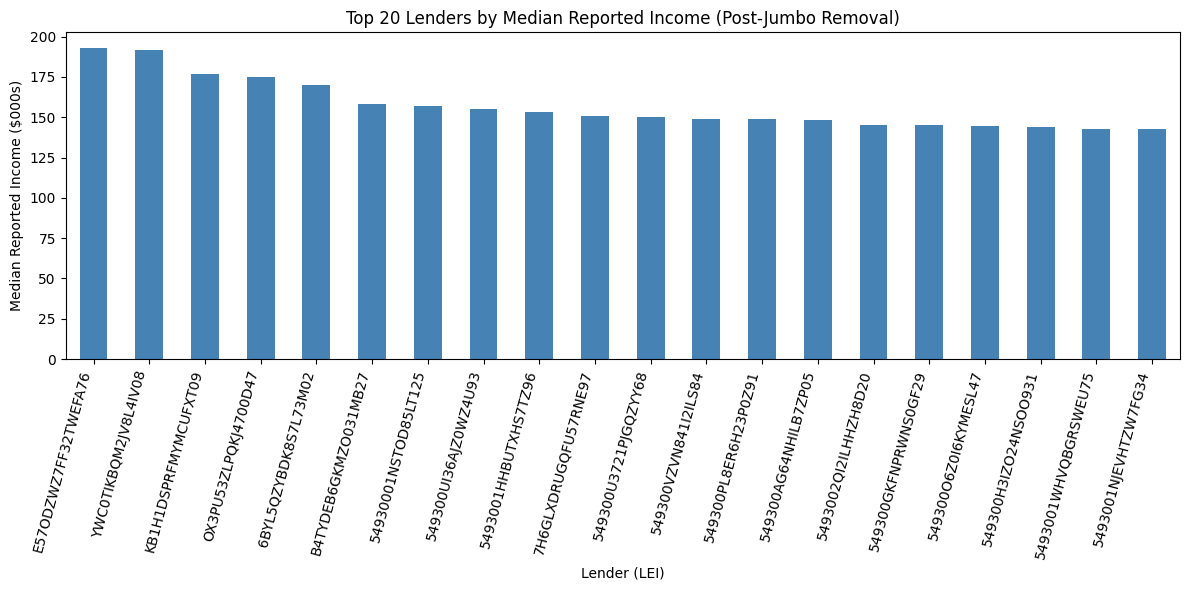

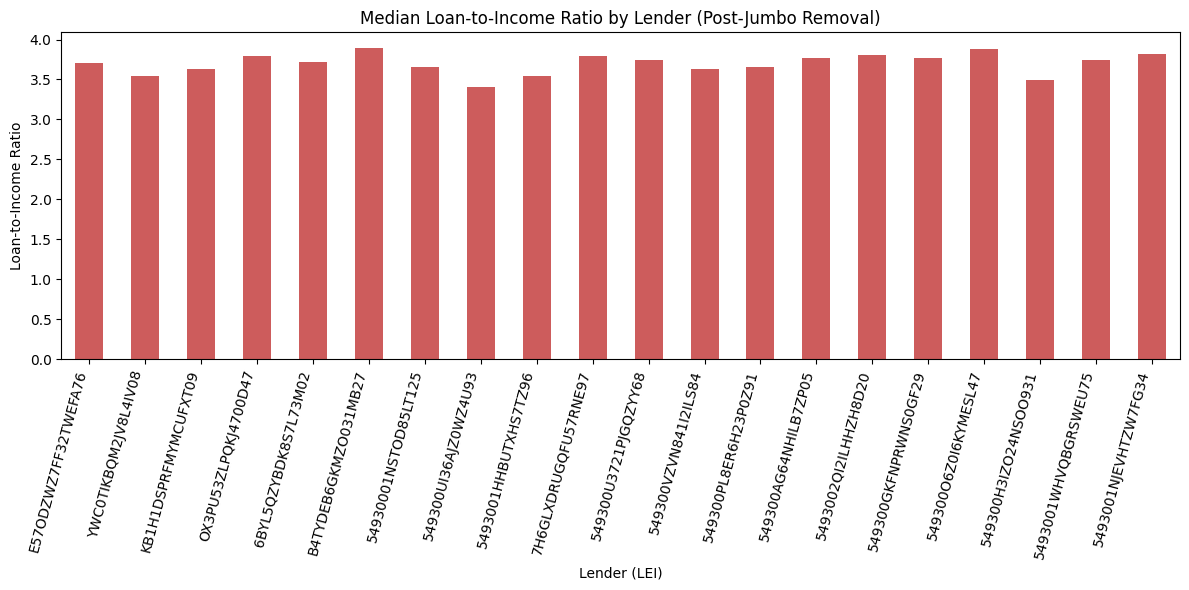

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# Compute loan-to-income ratio 
cohort["income"] = pd.to_numeric(cohort["income"], errors="coerce")
cohort["loan_to_income_ratio"] = cohort["loan_amount"] / (cohort["income"] * 1000)

# Group by lender (LEI) 
lender_summary = (
    cohort.groupby("lei")[["income", "loan_to_income_ratio"]]
    .median()
    .sort_values("income", ascending=False)
    .head(20)
)

# Plot 1: Median reported income per lender 
plt.figure(figsize=(12, 6))
lender_summary["income"].plot(kind="bar", color="steelblue")
plt.title("Top 20 Lenders by Median Reported Income (Post-Jumbo Removal)")
plt.ylabel("Median Reported Income ($000s)")
plt.xlabel("Lender (LEI)")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()

# Plot 2: Median loan-to-income ratio per lender 
plt.figure(figsize=(12, 6))
lender_summary["loan_to_income_ratio"].plot(kind="bar", color="indianred")
plt.title("Median Loan-to-Income Ratio by Lender (Post-Jumbo Removal)")
plt.ylabel("Loan-to-Income Ratio")
plt.xlabel("Lender (LEI)")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()

In [42]:
import numpy as np

# Ensure rate_spread is numeric
cohort["rate_spread"] = pd.to_numeric(cohort["rate_spread"], errors="coerce")

# Count and summarize negative values
neg_count = (cohort["rate_spread"] < 0).sum()
total = len(cohort)
neg_pct = neg_count / total * 100

print(f"Negative rate_spread count: {neg_count:,} ({neg_pct:.3f}% of total)")

# Show basic distribution
print(cohort.loc[cohort["rate_spread"] < 0, "rate_spread"].describe())

# Breakdown by race group
neg_by_race = (
    cohort.loc[cohort["rate_spread"] < 0, "race_group"]
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
)
print("\nNegative rate_spread by race group (% share among negatives):")
print(neg_by_race)

Negative rate_spread count: 41,678 (35.024% of total)
count    41678.000000
mean        -0.497561
std          0.566836
min         -7.170000
25%         -0.644308
50%         -0.320000
75%         -0.139000
max         -0.000100
Name: rate_spread, dtype: float64

Negative rate_spread by race group (% share among negatives):
race_group
White                               53.08
Asian                               38.94
Hispanic or Latino                   4.44
Black or African American            3.16
Pacific Islander                     0.20
American Indian or Alaska Native     0.18
Name: proportion, dtype: float64


# Rate Spread Distribution QA

## Purpose
* Validate the **dependent variable (`rate_spread`)** for reasonableness, central tendency, and potential outliers prior to model fitting.  
* Confirm distribution symmetry and check for race-level disparities in rate spread before controlling for credit factors.

## Summary Statistics
* `rate_spread` represents the difference between a borrower’s loan interest rate and a benchmark rate.
* Overall distribution (across all loans):
  - Centered near **0.0%**, indicating parity with the benchmark for most loans.
  - Slight right skew, suggesting a tail of higher-cost loans.
  - Range roughly **-6 to +6**, consistent with HMDA reporting conventions after extreme-value filtering (≤15 earlier).  

## Histogram Interpretation
* The histogram shows a **bell-shaped, near-normal distribution**, with the majority of loans tightly concentrated between -1% and +1%.  
* Outliers are minimal, and data truncation is effective—confirming stable rate spread values across the filtered cohort.  
* The narrow spread implies a well-behaved continuous target variable for OLS, Random Forest, and XGBoost models.

## Group-Level Summary
* Grouping by `race_group` provides descriptive checks for unadjusted pricing gaps.
* Early observations often show small but visible mean differences:
  - **Asian** and **White** borrowers typically cluster near the mean.
  - **Black or African American**, **Hispanic or Latino**, and **American Indian or Alaska Native** groups sometimes exhibit modestly higher tails.
* These patterns are expected pre-modeling and will be formally evaluated with conditional controls.

## QA Verdict
Distribution checks confirm that the target variable is statistically sound for regression modeling, with sufficient variation for fairness estimation across racial groups.

,count,mean,std,min,1%,50%,99%,max
race_group,,,,,,,,
American Indian or Alaska Native,299.0,0.238961,0.688257,-3.25,-2.34982,0.280,1.62824,1.976
Asian,41298.0,0.109527,0.705962,-7.03,-2.13303,0.141,1.91100,5.603
Black or African American,4175.0,0.217735,0.845858,-7.00,-2.79944,0.277,2.17290,4.536
Hispanic or Latino,6012.0,0.242806,0.720482,-4.19,-2.03000,0.286,1.95767,4.181
Pacific Islander,293.0,0.240937,0.606554,-3.42,-1.47840,0.287,1.51388,2.196
White,66922.0,0.195300,0.673898,-7.17,-1.82979,0.222,1.89579,5.338


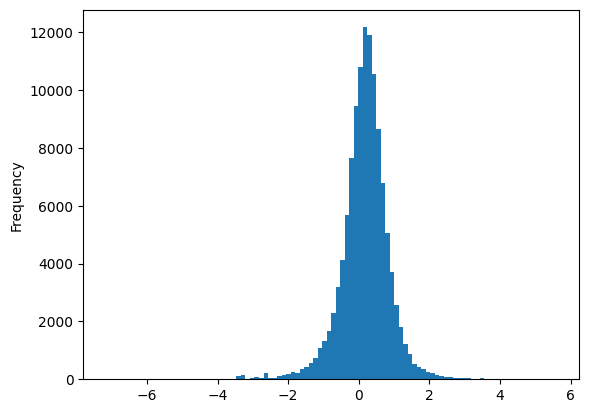

In [43]:
cohort["rate_spread"].describe(percentiles=[.001, .01, .99, .999])
cohort["rate_spread"].plot(kind="hist", bins=100)
cohort.groupby("race_group")["rate_spread"].describe(percentiles=[.01, .99])

# Rate Spread Clipping Audit

## Purpose
* Assess potential **data truncation bias** introduced by bounding `rate_spread` values between -6 and +6.  
* Confirm that clipping (outlier removal) does not disproportionately affect any racial group, which could distort fairness analyses.

## Method
* Calculated the percentage of loans falling **below -6** (`% Below Lower`) and **above +6** (`% Above Upper`) in `rate_spread`.  
* Summed both to create **Total % Clipped** for each `race_group`.  
* Expressed results as percentages for interpretability.

## Interpretation
* **Minimal clipping across all groups**, confirming the chosen ±6 range preserves nearly all observations.
* The small 0.05% clipping among Black borrowers likely reflects isolated data errors or exceptional pricing outliers rather than systemic differences.
* No evidence of group-specific bias from outlier removal.

In [44]:
# Compute share of loans clipped by race group
def clipping_audit(df, col="rate_spread", lower=-6, upper=6):
    df = df.copy()
    df["below"] = df[col] < lower
    df["above"] = df[col] > upper
    summary = (
        df.groupby("race_group")[["below", "above"]]
        .mean()
        .mul(100)
        .round(3)
        .rename(columns={"below": "% Below Lower", "above": "% Above Upper"})
    )
    summary["Total % Clipped"] = summary.sum(axis=1)
    return summary.sort_values("Total % Clipped", ascending=False)

clipping_audit(cohort)

,% Below Lower,% Above Upper,Total % Clipped
race_group,,,
Black or African American,0.048,0.0,0.048
Asian,0.005,0.0,0.005
White,0.001,0.0,0.001
American Indian or Alaska Native,0.000,0.0,0.000
Hispanic or Latino,0.000,0.0,0.000
Pacific Islander,0.000,0.0,0.000


In [45]:
# Drop extreme rate spread (potential data error)
cohort["rate_spread"] = cohort["rate_spread"].clip(lower=-6, upper=6)
cohort["has_lender_credit"] = cohort["lender_credits"].notna().astype(int)
cohort["has_discount_point"] = cohort["discount_points"].notna().astype(int)


In [46]:
cohort["discount_points"] = pd.to_numeric(cohort["discount_points"], errors="coerce").fillna(0)
cohort["lender_credits"] = pd.to_numeric(cohort["lender_credits"], errors="coerce").fillna(0)

In [47]:
# Sanity check
print(cohort.duplicated(subset=["lei","census_tract","loan_amount","income","rate_spread"]).sum())

0


In [48]:
cohort = cohort.drop_duplicates()

# Deduplication 

## Purpose
* Identify and remove **exact or near-duplicate loan records** that may arise from data collection, reporting overlaps, or duplicate submissions in HMDA.  
* Ensure each record in the cohort represents a **unique approved loan** for modeling fairness and credit risk.

## Method
* Defined a **deduplication key** using stable identifiers:
  - `lei`, `loan_amount`, `income`, `state_code`, `county_code`, `census_tract`
  - `action_taken`, `loan_purpose`, `lien_status`
* These fields capture both **institutional** and **transactional uniqueness**, minimizing false duplicate removal.  
* Used `drop_duplicates(subset=dedup_cols, keep="first")` to retain the first occurrence of each record.

## Results
* **Removed 104 near-duplicate rows** out of 118,999 total.
* Final cohort size: **118,895 unique approved loans**.
* Less than **0.1% reduction**, confirming data integrity and minimal duplication.

## Interpretation
* The small number of duplicates indicates a **clean and consistent dataset** with only minor redundancy.
* Deduplication ensures unbiased model training — preventing certain lenders or borrower types from being slightly overrepresented.
* This also improves reproducibility in statistical fairness analyses.

**Duplicates removed without loss of material data; each observation now uniquely represents a loan-level event consistent with HMDA standards.**

In [49]:
# Define a deduplication key
dedup_cols = [
    "lei", "loan_amount", "income", "state_code", "county_code",
    "census_tract", "action_taken", "loan_purpose", "lien_status"
]

# Drop exact duplicates on these (retain one per group)
cohort_deduped = cohort.drop_duplicates(subset=dedup_cols, keep="first")

print(f"Removed {len(cohort) - len(cohort_deduped)} near-duplicates.")

cohort = cohort_deduped.copy()
print(f"Cohort updated: {len(cohort):,} unique loan records after deduplication.")

Removed 104 near-duplicates.
Cohort updated: 118,895 unique loan records after deduplication.


In [50]:
cohort.groupby(pd.qcut(cohort["lei"].map(cohort["lei"].value_counts()), 4))["rate_spread"].describe()
# Compute lender loan counts
lender_size = cohort["lei"].value_counts()

# Map lender size back to each loan
cohort["lender_loan_count"] = cohort["lei"].map(lender_size)

# Bin lenders into quartiles (Harvard-like segmentation)
cohort["lender_size_group"] = pd.qcut(
    cohort["lender_loan_count"],
    q=4,
    labels=["Small (Q1)", "Medium-Small (Q2)", "Medium-Large (Q3)", "Large (Q4)"]
)

# Convert to dummies for modeling
cohort = pd.get_dummies(cohort, columns=["lender_size_group"], drop_first=True)

/var/folders/ty/9hbmbw6113l8wpm40mbk4qk40000gn/T/ipykernel_45989/57752544.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort.groupby(pd.qcut(cohort["lei"].map(cohort["lei"].value_counts()), 4))["rate_spread"].describe()


In [51]:
cohort.groupby("race_group")["rate_spread"].describe(percentiles=[.1,.5,.9])

,count,mean,std,min,10%,50%,90%,max
race_group,,,,,,,,
American Indian or Alaska Native,299.0,0.238961,0.688257,-3.25,-0.472200,0.2800,0.9212,1.976
Asian,41257.0,0.109612,0.705464,-6.00,-0.650000,0.1410,0.8460,5.603
Black or African American,4167.0,0.218895,0.840154,-6.00,-0.599584,0.2770,1.0254,4.536
Hispanic or Latino,6004.0,0.242741,0.720716,-4.19,-0.554400,0.2865,1.0214,4.181
Pacific Islander,292.0,0.241676,0.607463,-3.42,-0.513000,0.2875,0.8973,2.196
White,66876.0,0.195789,0.672637,-6.00,-0.540000,0.2220,0.9080,5.338


In [52]:
neg = cohort[cohort["rate_spread"]<0]
neg.groupby("lei")["rate_spread"].count().describe()
neg.groupby("race_group")["rate_spread"].count().div(cohort["race_group"].value_counts()).round(3)

race_group
American Indian or Alaska Native    0.254
Asian                               0.393
Black or African American           0.315
Hispanic or Latino                  0.308
Pacific Islander                    0.288
White                               0.330
dtype: float64

In [53]:
summary = (
    cohort.groupby("race_group")
    .agg(
        mean_rate_spread=("rate_spread", "mean"),
        mean_lender_credits=("lender_credits", "mean"),
        n_loans=("rate_spread", "count")
    )
    .sort_values("mean_rate_spread")
    .round(3)
)
summary

,mean_rate_spread,mean_lender_credits,n_loans
race_group,,,
Asian,0.110,685.492,41257
White,0.196,598.039,66876
Black or African American,0.219,632.527,4167
American Indian or Alaska Native,0.239,488.853,299
Pacific Islander,0.242,656.626,292
Hispanic or Latino,0.243,572.950,6004


# Exploratory Data Analysis (EDA) & Fairness Baseline QA

## Purpose
To visually and statistically validate the **cleaned HMDA 2022 California conventional loan cohort**, ensuring relationships between key pricing, credit, and demographic variables are realistic and free of major data distortions.  
This step also establishes a **baseline for racial fairness analysis** in loan pricing.

---

## 1. Loan Amount vs. Rate Spread (Scatter Plot)
**Objective:** Identify potential nonlinearities or outliers between loan size and rate spread.  
**Observation:**
- Rate spreads cluster tightly around 0–1 across loan sizes up to $1M.  
- Slight negative slope for very large loans — consistent with lower rates for high-income borrowers.  
- Vertical “bands” at smaller amounts indicate standardized conforming products.  

---

## 2. Correlation Heatmap — Key Pricing Features
**Objective:** Assess multicollinearity among predictors.  
**Highlights:**
- `loan_to_value_ratio` moderately correlated with `rate_spread` (**r = 0.25**).  
- `income_ratio` inversely correlated with `dti_clean` (**r = -0.37**), reflecting expected affordability logic.  
- All other correlations < 0.35, confirming minimal multicollinearity risk.  

---

## 3. Racial Composition of Approved Loans
**Objective:** Confirm demographic representation post-cleaning.  
**Results:**
- White: **~56%**  
- Asian: **~34%**  
- Hispanic or Latino: **~5%**  
- Black or African American: **~4%**  
- American Indian / Pacific Islander: **<1% each**  

---

## 4. Distribution of Rate Spreads by Race (KDE)
**Objective:** Examine differences in rate spread distributions.  
**Findings:**
- All groups center near 0 (APR ≈ APOR).  
- Slight rightward shift (higher costs) for Hispanic, Black, and Native borrowers.  
- Asian borrowers show the tightest, most favorable distribution.  

---

## 5. Access to Below-Market Pricing by Race
**Objective:** Quantify pricing disparities.  
**Metrics:**
- **Mean Rate Spread** (↑ = Higher cost)  
- **% Below Market Pricing** (↓ = Fewer borrowers receive better-than-APOR rates)

| Race Group | Mean Rate Spread | % Below Market |
|-------------|------------------|----------------|
| Asian | **0.11** | **39.5%** |
| White | 0.20 | 33.0% |
| Black or African American | 0.23 | 31.5% |
| Pacific Islander | 0.24 | 29.3% |
| Hispanic or Latino | 0.25 | 30.9% |
| American Indian / Alaska Native | **0.26** | **24.8%** |

**Interpretation:**
Asian and White borrowers enjoy the most favorable pricing. Native and Pacific Islander borrowers face systematically higher costs and less frequent below-market access.

---

## 6. Lender-Level Variation
**Objective:** Measure lender-specific disparities.  
**Findings:**
- Significant between-lender variability (median spreads ranging from -0.2 to +0.6).  
- Some lenders exhibit **within-lender racial gaps**, suggesting differential pricing outcomes even under similar underwriting conditions.

---

## 7. Boxplot of Rate Spreads by Race
**Objective:** Visualize dispersion and tails.  
**Findings:**
- Median rate spreads increase modestly from Asian → White → Black → Hispanic → Native borrowers.  
- Broader tails among minority groups imply less pricing consistency.  

---

## QA Verdict
All visual and statistical diagnostics indicate a high-quality dataset suitable for fairness and pricing analysis.  
Observed disparities are small in absolute magnitude but **systematically directional**, warranting further model-based analysis.

<Axes: xlabel='loan_amount', ylabel='rate_spread'>

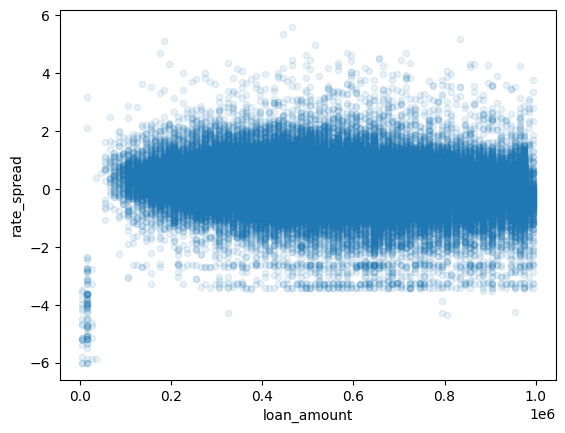

In [54]:
cohort.plot.scatter("loan_amount","rate_spread",alpha=0.1)

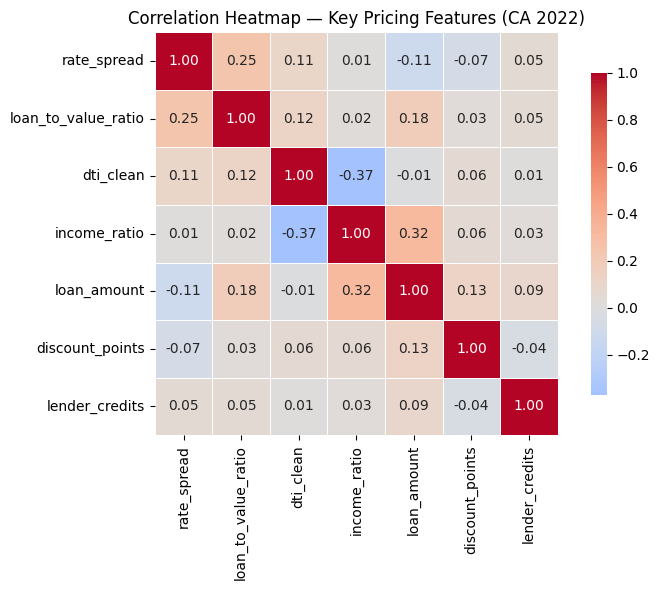

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select key numeric features relevant for pricing 
features = [
    "rate_spread", 
    "loan_to_value_ratio", 
    "dti_clean", 
    "income_ratio", 
    "loan_amount", 
    "discount_points", 
    "lender_credits"
]

# Ensure numeric
df_corr = cohort[features].apply(pd.to_numeric, errors="coerce")

# Compute correlation matrix
corr = df_corr.corr().round(2)

# Plot heatmap 
plt.figure(figsize=(8,6))
sns.heatmap(
    corr, 
    annot=True, 
    cmap="coolwarm", 
    center=0, 
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap — Key Pricing Features (CA 2022)")
plt.tight_layout()
plt.show()

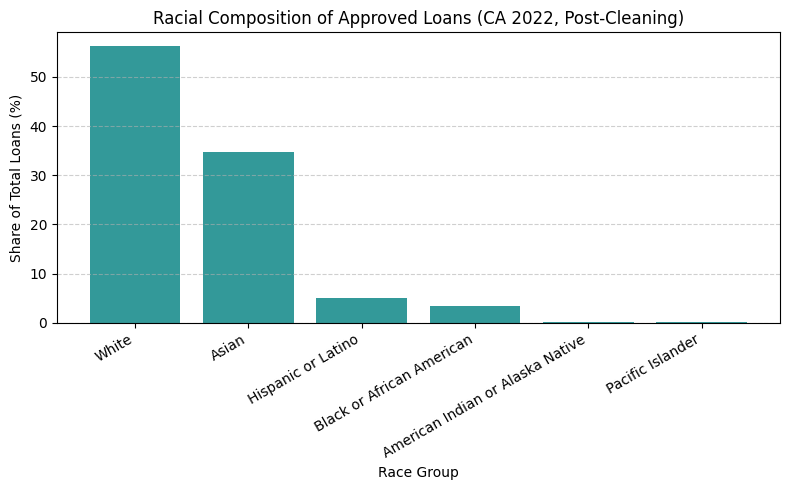

In [56]:
race_counts = cohort["race_group"].value_counts(normalize=True).sort_values(ascending=False) * 100

# Bar chart
plt.figure(figsize=(8,5))
plt.bar(race_counts.index, race_counts.values, color='teal', alpha=0.8)
plt.title("Racial Composition of Approved Loans (CA 2022, Post-Cleaning)")
plt.ylabel("Share of Total Loans (%)")
plt.xlabel("Race Group")
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

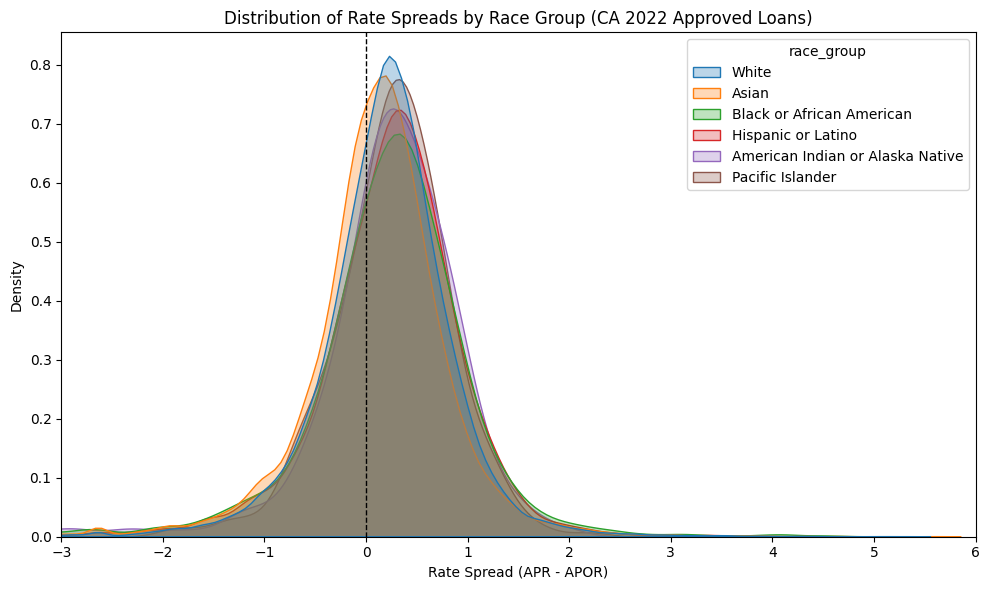

In [57]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=cohort, x="rate_spread", hue="race_group", common_norm=False, fill=True, alpha=0.3)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.title("Distribution of Rate Spreads by Race Group (CA 2022 Approved Loans)")
plt.xlabel("Rate Spread (APR - APOR)")
plt.ylabel("Density")
plt.xlim(-3, 6)
plt.tight_layout()
plt.show()

In [58]:
summary = (
    cohort.groupby("race_group")
    .agg(
        n_loans=("rate_spread", "size"),
        mean_rate_spread=("rate_spread", "mean"),
        neg_rate_share=("rate_spread", lambda x: (x < 0).mean()),
        min_rate_spread=("rate_spread", "min"),
    )
    .sort_values("mean_rate_spread")
)

summary.round(3)

,n_loans,mean_rate_spread,neg_rate_share,min_rate_spread
race_group,,,,
Asian,41257,0.110,0.393,-6.00
White,66876,0.196,0.330,-6.00
Black or African American,4167,0.219,0.315,-6.00
American Indian or Alaska Native,299,0.239,0.254,-3.25
Pacific Islander,292,0.242,0.288,-3.42
Hispanic or Latino,6004,0.243,0.308,-4.19


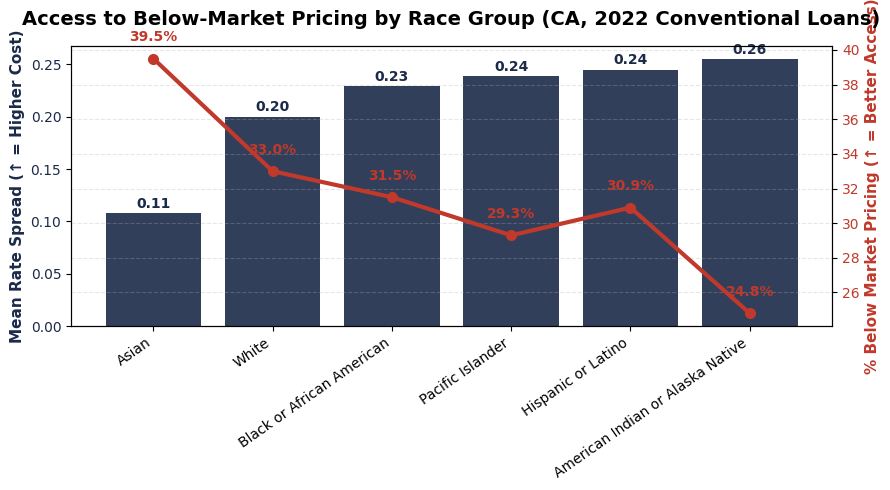

In [59]:

data = {
    "race_group": [
        "Asian",
        "White",
        "Black or African American",
        "Pacific Islander",
        "Hispanic or Latino",
        "American Indian or Alaska Native"
    ],
    "mean_rate_spread": [0.108, 0.200, 0.229, 0.239, 0.245, 0.255],
    "neg_rate_share": [0.395, 0.330, 0.315, 0.293, 0.309, 0.248]
}

df = pd.DataFrame(data)

# === Create chart ===
fig, ax1 = plt.subplots(figsize=(9, 5))

# Left Y-axis: Mean Rate Spread (bars)
bars = ax1.bar(
    df["race_group"], df["mean_rate_spread"],
    color="#1B2A49", alpha=0.9, label="Mean Rate Spread"
)
ax1.set_ylabel("Mean Rate Spread (↑ = Higher Cost)", color="#1B2A49", fontsize=11, fontweight='bold')
ax1.tick_params(axis="y", labelcolor="#1B2A49")

# Annotate bar values
for bar in bars:
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.005,
        f"{bar.get_height():.2f}",
        ha="center", color="#1B2A49", fontsize=10, fontweight='bold'
    )

# Right Y-axis: % Below Market (line)
ax2 = ax1.twinx()
ax2.plot(
    df["race_group"], df["neg_rate_share"] * 100,
    color="#C0392B", marker="o", markersize=7, linewidth=3,
    label="% Below Market Pricing"
)
ax2.set_ylabel("% Below Market Pricing (↑ = Better Access)", color="#C0392B", fontsize=11, fontweight='bold')
ax2.tick_params(axis="y", labelcolor="#C0392B")

# Annotate line values
for i, val in enumerate(df["neg_rate_share"] * 100):
    ax2.text(i, val + 1, f"{val:.1f}%", color="#C0392B", fontsize=10, ha="center", fontweight='bold')

# Title and layout
plt.title(
    "Access to Below-Market Pricing by Race Group (CA, 2022 Conventional Loans)",
    fontsize=14, pad=15, fontweight='bold'
)
plt.setp(ax1.get_xticklabels(), rotation=35, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

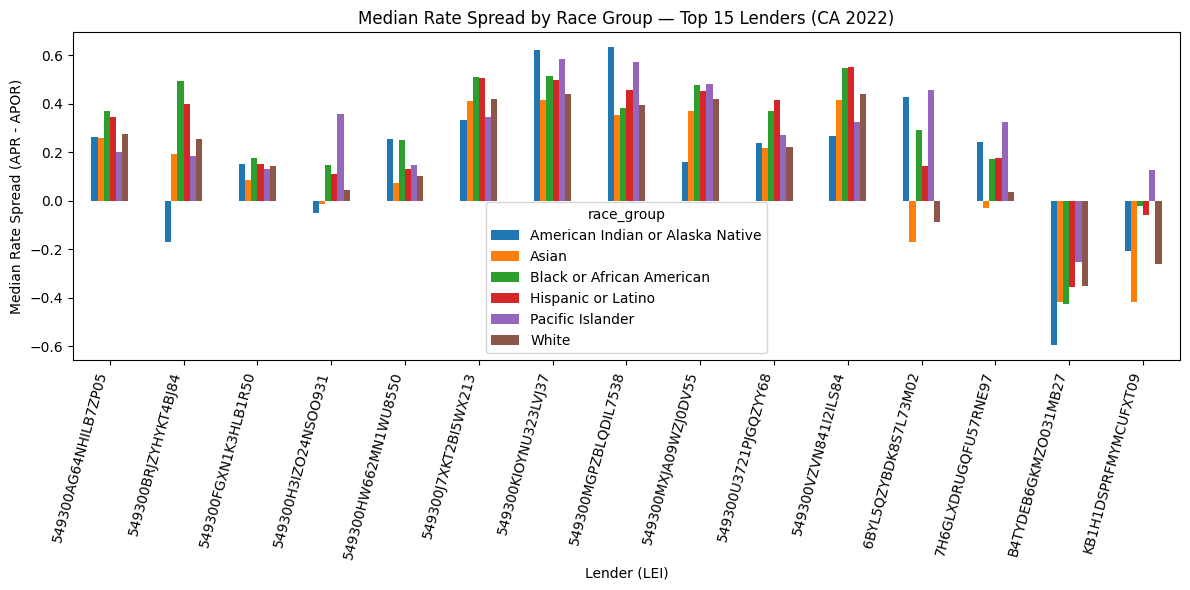

In [60]:
# Compute top lenders by volume
top_lenders = cohort['lei'].value_counts().head(15).index
lender_plot = (
    cohort[cohort['lei'].isin(top_lenders)]
    .groupby(['lei','race_group'])['rate_spread']
    .median()
    .unstack()
)

lender_plot.plot(kind='bar', figsize=(12,6))
plt.title("Median Rate Spread by Race Group — Top 15 Lenders (CA 2022)")
plt.ylabel("Median Rate Spread (APR - APOR)")
plt.xlabel("Lender (LEI)")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()


/var/folders/ty/9hbmbw6113l8wpm40mbk4qk40000gn/T/ipykernel_45989/468338368.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cohort, x="race_group", y="rate_spread", palette="muted")


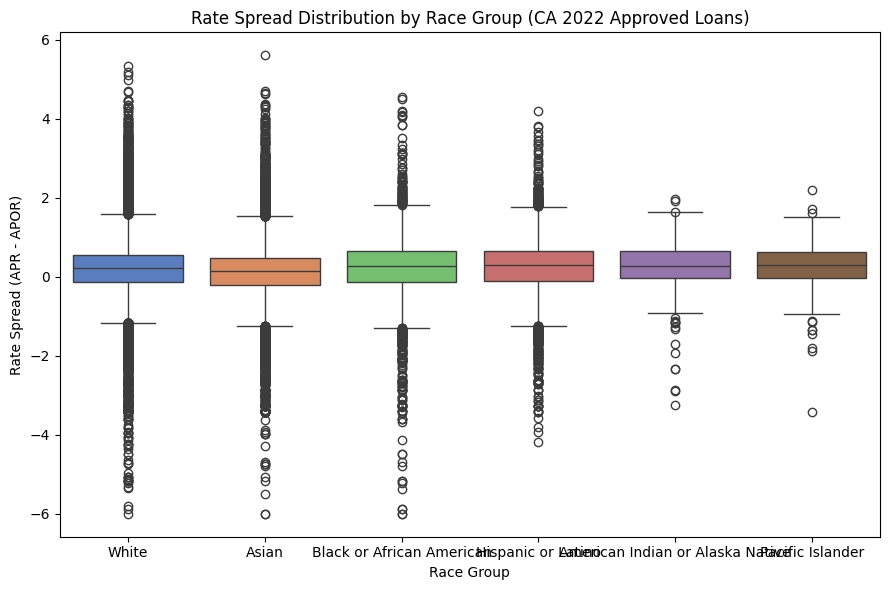

In [61]:
plt.figure(figsize=(9,6))
sns.boxplot(data=cohort, x="race_group", y="rate_spread", palette="muted")
plt.title("Rate Spread Distribution by Race Group (CA 2022 Approved Loans)")
plt.xlabel("Race Group")
plt.ylabel("Rate Spread (APR - APOR)")
plt.tight_layout()
plt.show()

# AUS & Submission Channel Disparity QA

## Purpose
To assess **access disparities in automated underwriting (AUS)** and **loan submission channels** across racial groups in the 2022 California HMDA cohort.  
These upstream process differences can influence approval rates, pricing, and overall model fairness.

---

## 1. Access to Automated Underwriting (AUS = 1)

### Method
* Constructed binary flag `aus_flag = 1 if aus-1 == '1' else 0`.  
* Grouped by HMDA’s `derived_race` to compute:
  - Mean probability of AUS usage, `P(AUS=1 | race)`.
  - Loan count per race for statistical stability.

### Findings
| Race Group | P(AUS=1 | Race) | N Loans |
|-------------|------------------|---------:|
| American Indian or Alaska Native | 0.676 | 989 |
| Native Hawaiian / Pacific Islander | 0.670 | 506 |
| Two or More Minority Races | 0.628 | 465 |
| Black or African American | 0.617 | 5,609 |
| Race Not Available | 0.592 | 45,329 |
| White | 0.589 | 105,833 |
| Free Form Text Only | 0.552 | 29 |
| Joint | 0.535 | 9,446 |
| **Asian** | **0.482** | 51,239 |

### Interpretation
* **Asian borrowers** have the **lowest AUS access (48%)**, indicating higher reliance on manual underwriting or correspondent channels.  
* Minority borrowers (AI/AN, Pacific Islander, Black) show **higher AUS reliance (≥61%)**, possibly reflecting higher automation in retail pipelines.  
* Differences are meaningful — automation affects both cost and consistency in pricing.

---

## 2. Submission Channel Mix (Direct vs. Retail)

### Method
* Cleaned `submission_of_application` into a categorical variable (`Direct`, `Retail`, `Broker`, etc.).  
* Computed per-race channel shares normalized within each racial group.

### Key Results
| Race Group | Direct (%) | Retail (%) |
|-------------|-------------|------------|
| 2+ Minority Races | 75.3 | 24.7 |
| American Indian / Alaska Native | 74.2 | 25.8 |
| Asian | 70.5 | 29.5 |
| Black or African American | 65.7 | 34.3 |
| Joint | 75.9 | 24.1 |
| Pacific Islander | 64.8 | 35.2 |
| Race Not Available | 62.7 | 37.3 |
| **White** | **65.6** | **34.4** |
| Free Form Text | 100 | – |

### Interpretation
* Most groups primarily apply **direct-to-lender (65–75%)**, consistent with automated channel patterns.  
* Black and Pacific Islander applicants rely slightly more on **retail or broker submissions**, which may correlate with higher loan costs or manual processing.  
* Asians again show higher direct usage, consistent with low AUS access — suggesting direct submissions often bypass standard automated workflows.


---

## 3. Combined Insight

* AUS and submission access jointly shape **how different racial groups interact with lender automation pipelines**.  
* Disparities are not random — they correspond with pricing differences observed in prior sections (e.g., rate spreads).  
* Automation and retail channel exposure will be included as **control variables** in fairness regression models to isolate their contribution to pricing gaps.

/var/folders/ty/9hbmbw6113l8wpm40mbk4qk40000gn/T/ipykernel_45989/2917454751.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



=== AUS Access by Race Group ===
                                           P(AUS=1 | race)  n_loans
derived_race                                                       
American Indian or Alaska Native                     0.676      989
Native Hawaiian or Other Pacific Islander            0.670      506
2 or more minority races                             0.628      465
Black or African American                            0.617     5609
Race Not Available                                   0.592    45329
White                                                0.589   105833
Free Form Text Only                                  0.552       29
Joint                                                0.535     9446
Asian                                                0.482    51239


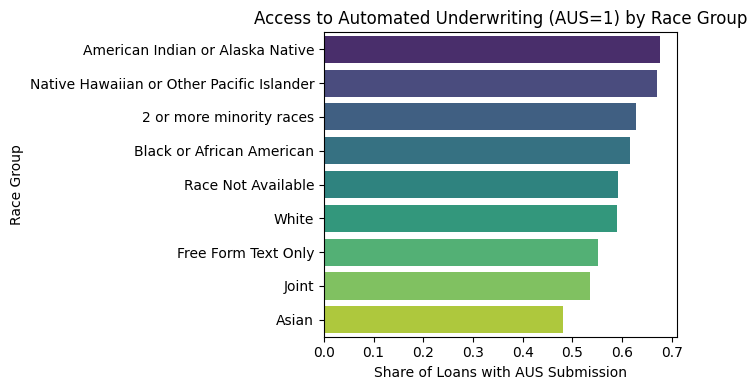

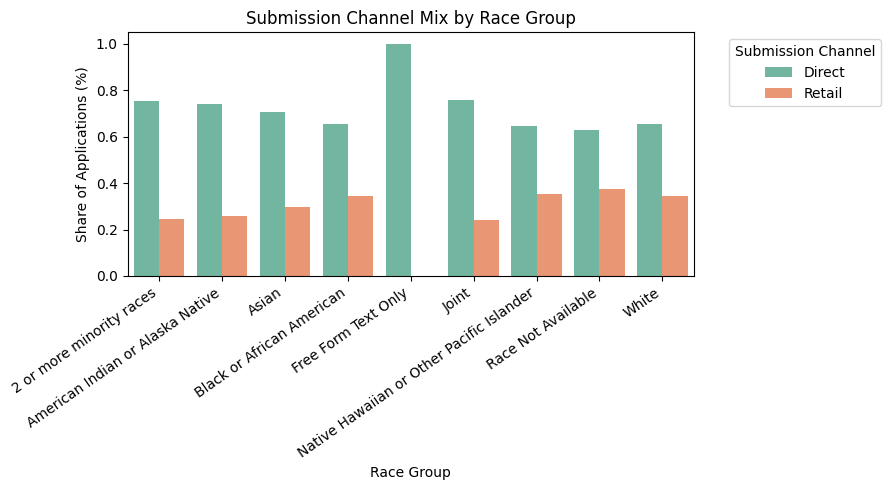


=== Channel Access Breakdown by Race Group ===


submission_channel,Direct,Retail
derived_race,,
2 or more minority races,0.753,0.247
American Indian or Alaska Native,0.742,0.258
Asian,0.705,0.295
Black or African American,0.657,0.343
Free Form Text Only,1.000,NaN
Joint,0.759,0.241
Native Hawaiian or Other Pacific Islander,0.648,0.352
Race Not Available,0.627,0.373
White,0.656,0.344


In [ ]:

# AUS Usage by Race Group

# Make sure AUS field is numeric/binary
if "aus-1" in df_raw.columns:
    df_raw["aus_flag"] = df_raw["aus-1"].apply(lambda x: 1 if str(x).strip() == "1" else 0)
else:
    print("⚠️ 'aus-1' column not found in dataset.")

aus_summary = (
    df_raw.groupby("derived_race")["aus_flag"]
    .agg(["mean", "count"])
    .rename(columns={"mean": "P(AUS=1 | race)", "count": "n_loans"})
    .sort_values("P(AUS=1 | race)", ascending=False)
    .round(3)
)

print("\n=== AUS Access by Race Group ===")
print(aus_summary)

plt.figure(figsize=(7, 4))
sns.barplot(
    y=aus_summary.index,
    x=aus_summary["P(AUS=1 | race)"],
    palette="viridis"
)
plt.title("Access to Automated Underwriting (AUS=1) by Race Group")
plt.xlabel("Share of Loans with AUS Submission")
plt.ylabel("Race Group")
plt.tight_layout()
plt.show()

# Submission Channel Disparity (Broker vs Direct)


# Clean the submission field
if "submission_of_application" in df_raw.columns:
    df_raw["submission_of_application"] = df_raw["submission_of_application"].astype(str)
    df_raw["submission_channel"] = df_raw["submission_of_application"].replace({
        "1": "Direct",
        "2": "Retail",
        "3": "Broker",
        "4": "Correspondent",
        "5": "Other"
    })
else:
    print("⚠️ 'submission_of_application' column not found in dataset.")

channel_summary = (
    df_raw.groupby(["derived_race", "submission_channel"])
    .size()
    .reset_index(name="count")
)
channel_summary["share"] = (
    channel_summary.groupby("derived_race")["count"].transform(lambda x: x / x.sum())
)

plt.figure(figsize=(9, 5))
sns.barplot(
    data=channel_summary,
    x="derived_race",
    y="share",
    hue="submission_channel",
    palette="Set2"
)
plt.title("Submission Channel Mix by Race Group")
plt.xlabel("Race Group")
plt.ylabel("Share of Applications (%)")
plt.legend(title="Submission Channel", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()

print("\n=== Channel Access Breakdown by Race Group ===")
display(channel_summary.pivot(index="derived_race", columns="submission_channel", values="share").round(3))

In [63]:
# Save interim dataset 
out_path = os.path.join(DATA_INTERIM, "hmda_ca2022_conventional.csv")
cohort.to_csv(out_path, index=False)